# Handle missing values in Categorical Features

We will be use the [Classified Ads for Cars](https://www.kaggle.com/mirosval/personal-cars-classifieds) dataset to predict the price of the ADs. This dataset is full of missing values, categorical and not. Our aim will be a simple Regression problem. To archieve this we will focus on a particular categorical feature, the **maker**.

* **Replace** missing values with the *most frequent values*. It could lead to an unbalanced dataset.
* **Delete** rows with null values. It could lead to a loss of too many useful informations.
* **Predict** values using a Classifier Algorithm (supervised or unsupervised)


## Steps
* **Show Raw Data**: let's see how raw data looks like.
* **Some Feature Engineering**: data cleaning and extraction of new features.
* **Models**: we will deal missing values comparing different techniques.
* **Conclusions**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

## Show Raw Data
Let's see how raw data looks like

In [2]:
import zipfile

filename = "cars.csv"

with zipfile.ZipFile(filename + ".zip", 'r') as zip_ref:
    zip_ref.extractall("")

dtypes = {
    "maker": str, # brand name
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float, # CC
    "engine_power": float, # CV
    "body_type": str, # almost never present
    "color_slug": str, # also almost never present
    "stk_year": str,
    "transmission": str, # automatic or manual
    "door_count": str,
    "seat_count": str,
    "fuel_type": str, # gasoline, diesel, cng, lpg, electric
    "date_created": str, # when the ad was scraped
    "date_last_seen": str, # when the ad was last seen. Dataset policy was to remove all ads older than 60 days
    "price_eur": float} # list price converted to EUR

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [3]:
# Missing values
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [4]:
# Here we can see strage data, like the Min() and the Max() of some features
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,3.19033e+06,3.18233e+06,2.8095e+06,2.99804e+06,3.55291e+06
mean,115814,2000.87,2043.96,98.468,1.62581e+06
std,342251,81.7259,1973.96,49.0731,2.02562e+09
min,0,0,0,1,0.04
25%,18800,2004,1400,68,1295.34
50%,86415,2009,1798,86,7364.91
75%,158025,2013,1997,110,16284.2
max,1e+07,2017,32767,2237,2.70615e+12


## Some Feature Engineering

In [5]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 150.00]
# df = df[df["mileage"] < 800000.00]
# df = df[df["engine_displacement"] < 3000.00]
# df = df[df["engine_power"] < 1000.00]


# Manufacture Year
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# Engine Power
min_engine_power = 50
average = df.loc[df["engine_power"] >= min_engine_power].\
groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_power"] < min_engine_power, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Displacement
min_engine_displacement = 600
average = df.loc[df["engine_displacement"] >= min_engine_displacement].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < min_engine_displacement, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["avg_engine_displacement"])
df = df[df['engine_displacement'].notna()]

# Mileage
features_to_fillna = ["mileage"]
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduce the mean
    df[feature].fillna(replace_with,inplace=True)


In [6]:
# let's transform str dates in datetimes and creare a new feature with the duration of ADs
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

**Replace** missing values with the *most frequent values*

In [7]:
# 
features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduce the median
    df[feature].fillna(replace_with,inplace=True)             # replace null
    
df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

**Delete** rows with null values.

In [8]:
#
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])

In [9]:
# drop features
features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_power", "avg_engine_displacement"]
df = df.drop(features_to_drop, axis="columns")
df.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,74,0,1,0,0,1,0,1


In [10]:
# Missing values
print(df.isna().sum())

maker                  212897
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
price_eur                   0
ad_duration                 0
seat_str_large              0
seat_str_medium             0
seat_str_small              0
fuel_type_diesel            0
fuel_type_gasoline          0
transmission_auto           0
transmission_man            0
dtype: int64


Almost there! Now we just have to handle the **maker** feature, and we will do it with four different ways. Then, for each of them, we will create a simple model of Linear Regression for the prediction.

* **1st Model**: Delete the entire column *Maker*.
* **2nd Model**: Replace values with the mode.
* **3rd Model**: Delete rows with null values.
* **4th Model**: Predict the missing values with the RandomForestClassifier.

In [11]:
mse_list = []
r2_score_list = []
num_records_list = []

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

def plot_regression(Y_test, Y_pred):
    x = Y_test
    y = Y_pred

    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.plot(x, y, 'o')

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x + b)

## Delete the entire column *Maker*.

In [12]:
df_no_maker = df.copy()
df_no_maker = df_no_maker.drop("maker", axis="columns")

df_no_maker = remove_outliers(df_no_maker)

X = df_no_maker.drop("price_eur", axis=1).values
Y = np.log1p(df_no_maker["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_no_maker.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+ str(df_no_maker.shape[0]))

MSE: 0.12762562636297806
R2 score: 0.8562722044718778
Remaining rows: 853230


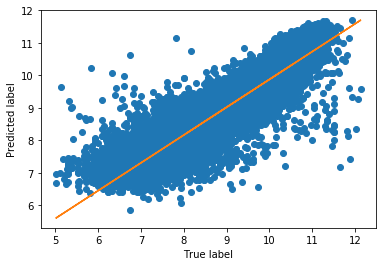

In [13]:
plot_regression(Y_test, Y_pred)

In [14]:
df_no_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
count,853230,853230,853230,853230,853230,853230,853230,853230,853230,853230,853230,853230,853230
mean,86884.6,2009.56,1807.35,97.9722,13310.3,45.2175,0,1,0,0.496757,0.503243,0.281918,0.718082
std,79025.4,5.12763,565.215,37.6439,11056.7,47.5425,0,0,0,0.49999,0.49999,0.449934,0.449934
min,0,1993,600,50,150.04,0,0,1,0,0,0,0,0
25%,16571,2006,1397,70,5403.4,10,0,1,0,0,0,0,0
50%,73494,2011,1689,90,10990,30,0,1,0,0,1,0,1
75%,139778,2014,1995,115,18022.3,61,0,1,0,1,1,1,1
max,793970,2016,5826,251,230009,180,0,1,0,1,1,1,1


## Replace values with the mode.

In [15]:
df_replace_mode = df.copy()

features_to_fillna = ["maker"]
for feature in features_to_fillna:
    replace_with = df_replace_mode[feature].mode()             # deduce the mode
    df_replace_mode[feature].fillna(replace_with,inplace=True) # replace null

df_replace_mode = pd.get_dummies(df_replace_mode,columns=["maker"])

df_replace_mode = remove_outliers(df_replace_mode)

X = df_replace_mode.drop("price_eur", axis=1).values
Y = np.log1p(df_replace_mode["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_replace_mode.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_replace_mode.shape[0]))

MSE: 0.10579114418300664
R2 score: 0.866585451152607
Remaining rows: 187254


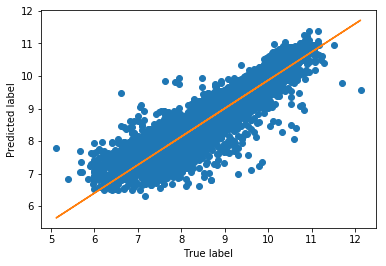

In [16]:
plot_regression(Y_test, Y_pred)

## Delete rows with null values.

In [17]:
df_del_rows = df.copy()

df_del_rows = df_del_rows[df_del_rows['maker'].notna()]
df_del_rows = pd.get_dummies(df_del_rows,columns=["maker"])

df_del_rows = remove_outliers(df_del_rows)

X = df_del_rows.drop("price_eur", axis=1).values
Y = np.log1p(df_del_rows["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_del_rows.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_del_rows.shape[0]))

MSE: 0.09196384992466516
R2 score: 0.8895823255526056
Remaining rows: 227196


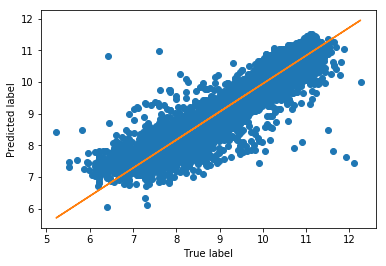

In [18]:
plot_regression(Y_test, Y_pred)

In [19]:
df_del_rows.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
count,227196,227196,227196,227196,227196,227196,227196,227196,227196,227196,...,227196,227196,227196,227196,227196,227196,227196,227196,227196,227196
mean,101527,2009.39,2216.2,128.25,19247.9,44.3485,0,1,0,0.645641,...,0,0,0,0,0,0,0,0,0,0
std,84356.7,5.21189,589.574,40.8391,13859.7,46.8835,0,0,0,0.47832,...,0,0,0,0,0,0,0,0,0,0
min,0,1993,600,51,166.54,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,26058,2006,1968,100,8893.3,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
50%,89000,2011,1995,125,17400,30,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
75%,157000,2014,2598,150,26013.4,61,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
max,793970,2016,6020,262,230009,180,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Predict the missing values.

In [20]:
df_with_maker = df[df['maker'].notna()]
# df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212897 entries, 9 to 1153195
Data columns (total 14 columns):
maker                  0 non-null object
mileage                212897 non-null float64
manufacture_year       212897 non-null float64
engine_displacement    212897 non-null float64
engine_power           212897 non-null float64
price_eur              212897 non-null float64
ad_duration            212897 non-null int64
seat_str_large         212897 non-null uint8
seat_str_medium        212897 non-null uint8
seat_str_small         212897 non-null uint8
fuel_type_diesel       212897 non-null uint8
fuel_type_gasoline     212897 non-null uint8
transmission_auto      212897 non-null uint8
transmission_man       212897 non-null uint8
dtypes: float64(5), int64(1), object(1), uint8(7)
memory usage: 14.4+ MB


ACCURACY: TRAIN=0.9630 TEST=0.9219
LOG LOSS: 0.2791199985420627


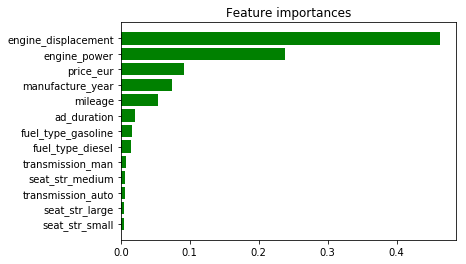

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
# print(indices)

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

#ACCURACY: TRAIN=0.9630 TEST=0.9219
#LOG LOSS: 0.2791199985420627

In [22]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

frames = [df_with_maker, df_no_maker]
df_final = pd.concat(frames)
print(len(df_final.index))
df_final.head()

961576


,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,74,0,1,0,0,1,0,1


In [23]:
df_no_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
count,212897,212897,212897,212897,212897,212897,212897,212897,212897,212897,212897,212897,212897
mean,104198,2009.1,1804.08,91.7592,12570.7,46.6393,0.0761965,0.888862,0.0349418,0.540858,0.459142,0.215419,0.784581
std,224582,5.75639,1093.41,37.4466,23405,48.4203,0.265313,0.314304,0.183633,0.498329,0.498329,0.411113,0.411113
min,0,1970,600,50,150.04,0,0,0,0,0,0,0,0
25%,23970,2006,1397,74,4922.28,10,0,1,0,0,0,0,1
50%,84112,2011,1598,81,10362.7,32,0,1,0,1,0,0,1
75%,150150,2014,1968,103,16342.4,61,0,1,0,1,1,0,1
max,1e+07,2016,32000,997,2.64737e+06,180,1,1,1,1,1,1,1


In [24]:
df_with_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
count,748679,748679,748679,748679,748679,748679,748679,748679,748679,748679,748679,748679,748679
mean,94771.2,2009.29,1990.93,105.941,15402.2,44.9929,0.0379869,0.928869,0.0331437,0.484206,0.515794,0.317985,0.682015
std,236377,5.67976,1344.98,52.1864,85858.7,47.3306,0.191165,0.257043,0.179012,0.499751,0.499751,0.465694,0.465694
min,0,1970,600,50,150.04,0,0,0,0,0,0,0,0
25%,15656,2006,1416,73,5514.43,10,0,1,0,0,0,0,0
50%,73000,2011,1799,94,11490.9,30,0,1,0,0,1,0,1
75%,139000,2014,2143,125,19576.8,61,0,1,0,1,1,1,1
max,1e+07,2016,32000,999,5.00296e+07,180,1,1,1,1,1,1,1


In [25]:
df_final.sort_values(by=['mileage'], inplace=True, ascending=False)
df_final.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
117051,mercedes-benz,9999999.0,1986.0,2996.0,80.0,2390.34,60,0,1,0,1,0,1,0
397020,chevrolet,9999999.0,1974.0,7212.0,276.0,28015.54,65,0,1,0,0,1,1,0
829999,porsche,9999999.0,1975.0,2956.0,132.0,33003.66,40,0,1,0,0,1,0,1
612951,chevrolet,9999999.0,1970.0,7636.0,276.0,12905.26,60,1,0,0,0,1,1,0
117619,mercedes-benz,9999999.0,1974.0,2562.0,116.0,7991.19,60,0,1,0,0,1,1,0
909247,nissan,9999999.0,1998.0,2188.0,83.0,600.00,11,0,1,0,1,0,0,1
309131,toyota,9999999.0,1988.0,1781.0,79.0,2801.67,15,0,1,0,0,1,0,1
660749,porsche,9999999.0,1987.0,2449.0,110.0,1100.41,7,0,1,0,0,1,0,1
1088796,fiat,9999999.0,2012.0,1223.0,58.0,2555.29,166,0,1,0,0,1,0,1
750086,opel,9999999.0,2010.0,1998.0,154.0,21506.37,22,0,0,1,0,1,0,1


In [26]:
df_final = pd.get_dummies(df_final,columns=["maker"])

df_final = remove_outliers(df_final)

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_final.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_final.shape[0]))

MSE: 0.08317979507305683
R2 score: 0.8896024150511559
Remaining rows: 243918


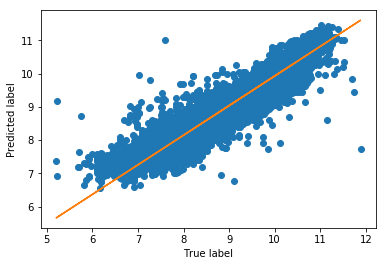

In [27]:
plot_regression(Y_test, Y_pred)

In [28]:
df_final.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
count,243918,243918,243918,243918,243918,243918,243918,243918,243918,243918,...,243918,243918,243918,243918,243918,243918,243918,243918,243918,243918
mean,93576.5,2009.9,1842.59,101.97,14915.7,47.6805,0,1,0,0.569839,...,0,0,0,0,0.462278,0,0,0,0,0
std,82941,4.85974,515.871,37.5174,11105.4,48.1414,0,0,0,0.495099,...,0,0,0,0,0.498576,0,0,0,0,0
min,0,1993,670,50,166.54,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,19000,2007,1416,77,6624.72,11,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
50%,80308.5,2011,1900,96,12879.4,34,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
75%,149800,2014,1968,120,20413.4,63,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
max,790000,2016,5800,251,219900,180,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


0	Delete the entire column Maker	0.127626	0.856272	853230

1	Replace values with the mode	0.105791	0.866585	187254

2	Delete rows with null values	0.091964	0.889582	227196

3	Predict the missing values	    0.083180	0.889602	241576

## Conclusions

In [29]:
options_list = [
    "Delete the entire column Maker", 
    "Replace values with the mode", 
    "Delete rows with null values", 
    "Predict the missing values"
]

df_metrics = pd.DataFrame({
    "": options_list,
    "MSE": mse_list,
    "R2_score": r2_score_list,
    "# Records": num_records_list
})
df_metrics.head()

,,MSE,R2_score,# Records
0,Delete the entire column Maker,0.127626,0.856272,853230
1,Replace values with the mode,0.105791,0.866585,187254
2,Delete rows with null values,0.091964,0.889582,227196
3,Predict the missing values,0.083180,0.889602,243918
